In [1]:
# Importer
import classes.utils as utils
from classes.splitter import Splitter
from classes.classifier_trainer import ClassifierTrainer
from classes.drift_detector import DriftDetector
from classes.mlflow_manager import MLflowManager

from sklearn.tree import DecisionTreeClassifier


import numpy as np

utils.set_parent_directory_as_working_directory()

# TODO: Move this to a config file
# Importing
DATA_FOLDER = "./data"


FE_DATA_PATH = DATA_FOLDER +'/fe_data.csv'
DATES_DATA_PATH = DATA_FOLDER +'/dates_data.csv'

SEED = 47


# 0 Introduction
In this notebook we will develop our first model. We are going to assume that we have 1 year of loans that have finished (finished_d = issued date + total length of loan), which basically place ourselves on 2011-05-01.

We need to use this variable and not issued_date because when you issue new loan you don't know yet if it's going to be fully paid or not. So we need to wait until the loan is finished to know if it was fully paid or not.


# 1 Splitting data
Before we get hands on with the modelling, we need to split the data into train and test sets. As we mentioned in the preprocessing notebook we will be using the create variable  'finished_d' to 

We will use the train set to train the model and the test set to evaluate the model. We will use the train_test_split function from sklearn to split the data. We will use 70% of the data for training and 30% for testing.

In [2]:
splitter_name = "splitter"

splitter = Splitter(
    name = splitter_name
    , data_path = FE_DATA_PATH
    , date_cols = []
    , target_variable = 'loan_status'
    , destination_directory = DATA_FOLDER
    , dates_data_path = DATES_DATA_PATH
    , column_to_split_by = 'finished_d'
    , test_size = 0.3
    , random_state = SEED
)

splitter.execute()


-------------- Executing splitter --------------
Data loaded from ./data/fe_data.csv
Dates data loaded from ./data/dates_data.csv
Test and train attributes defined 0.3.
        Test size: 678201
        Train size: 1582467
--------------- splitter finished ---------------


This object contains x_train, x_test, y_train and y_test, for the whole series later we can easily filter them by changing "number_of_months".

# 2 Modelling with MLOps methodology

In this part is where we are going to dig deeper into MLOps methodology and simulate what the process could be imagining that we start modelling after we have 1 year of finished loans (i.e. since the first loan finished). 

The main focus areas on this exercise will be:

- Deploying the model in production: we will use MLflow to deploy the model in production, obviously in a real scenario this would be much more complex, but here we are just going to worry to serve the model in a API

- Monitoring the model in production

- Detecting drifts: after every year of data we are going to monitor the model and detect if there is any drift in the input or target variables as well as if there is a change in the relationship between the these both (concept drift)

- Retraining the model: lastly we will retrain our model. We will use the challenger model approach, which basically means that we will train a new model and compare it with the current model. If the challenger model is better than the current model, we will replace the current model with the challenger model

## 2.2 First year of data

In [3]:
# create a list of 5 random integers
random_max_depth = np.random.randint(2, 30, 5)
splitter.set_train_test_filtered(number_of_months=12)


trainer_first_year = ClassifierTrainer(
    name = 'trainer_first_year'
    , model_class = DecisionTreeClassifier()
    , random_state=SEED
    , splitter = splitter
    , objective_metric = 'roc_auc'
)

trainer_first_year.train_grid_search(
    param_distributions = {'max_depth': random_max_depth
                           }  
)

trainer_first_year.predict(splitter.X_test)
trainer_first_year.evaluate(splitter.y_test)


Resampled data. New train size: 1179
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1179
Fitting grid search with 5 splits and 5 repeats
X_train shape: (1179, 132)
Best parameters: {'max_depth': 8}
Best cross-validation score: 0.63
Model trainer_first_year has made the predictions


Once the model has been trained and the predictions have been made on the test set we can see the metrics

In [4]:
trainer_first_year.results

{'accuracy': 0.6314907872696818,
 'precision': 0.8472622478386167,
 'recall': 0.6377440347071583,
 'f1': 0.7277227722772277,
 'roc_auc': 0.6240190761771086}

In MLlow we can now log the experiment and model in MLflow. We are going to consider this model the model in production as well.

We need to initialize the MLflow tracking server
```bash
mlflow server --backend-store-uri sqlite:///mydb.sqlite
```

In this case I am doing it locally [using a sqlite database as a backend store](https://mlflow.org/docs/latest/tracking.html#scenario-3-mlflow-on-localhost-with-tracking-server).

URL: http://127.0.0.1:5000

We are going to register out previous model using the mlflow.sklearn log_model function. This function will log the model in MLflow and will save the model in the folder 'mlartifacts' which in this case is our modle store.

Some other things that we are doing when calling run method is that we are logging the parameters after predicting on test. Also, when logging the model in the model store, we are [infering the signature](https://mlflow.org/docs/latest/python_api/mlflow.models.html?highlight=infer_signature#mlflow.models.infer_signature) which means that when calling the model the input and output (predictions) format of the data will be checked.


In [5]:
experiment_name = 'descision_tree'
mlflow_manager =  MLflowManager(
    name = 'mlflow_manager' 
)

mlflow_manager.make_run( run_name = 'first_year'
                        , experiment_name=experiment_name
                          , trainer=trainer_first_year
                          , log_model=True
                           )

Experiment random_forest created in tracking URI http://127.0.0.1:5000


/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Int

Model trainer_first_year logged in MLflow
Run completed


Created version '3' of model 'trainer_first_year'.


We can see how this parameters are logged in the UI

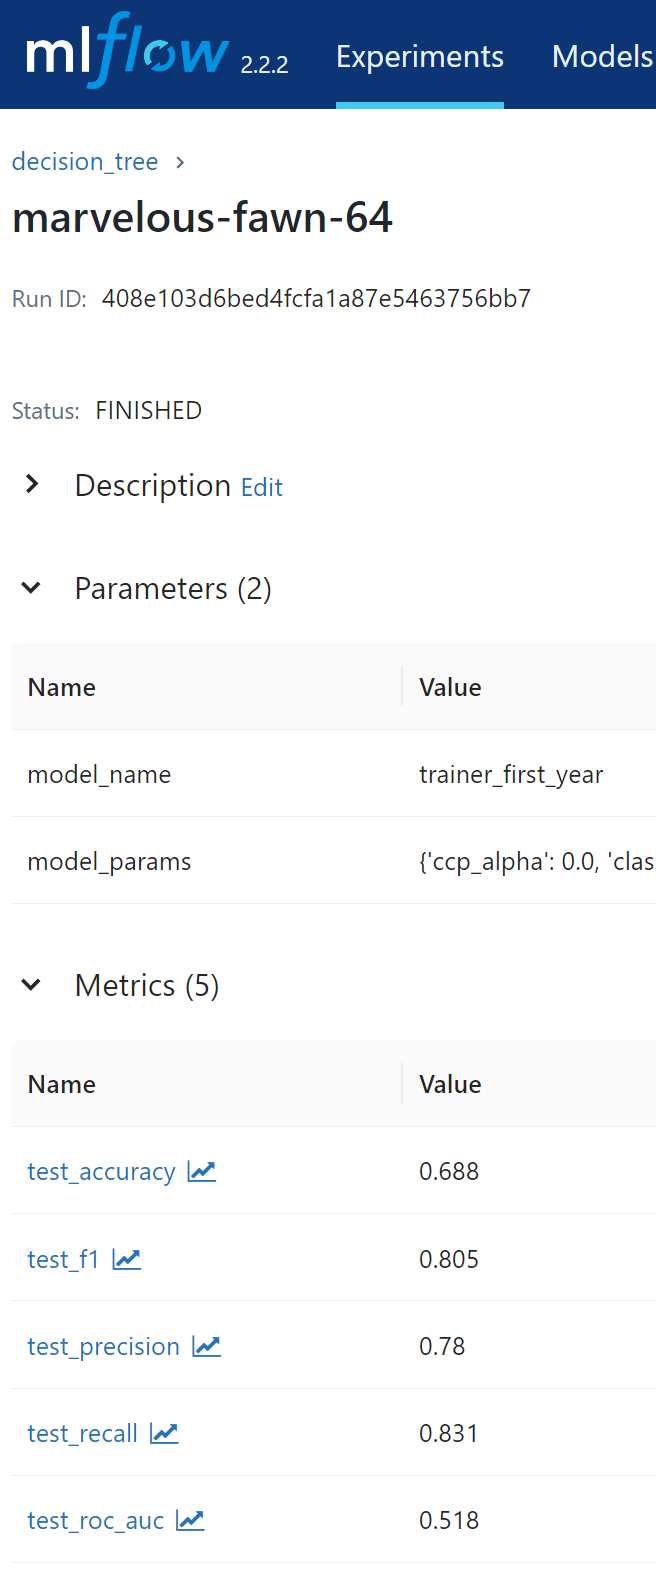

Let's set it as the production model

In [6]:
MLflowManager.set_model_stage(trainer_first_year.name, model_version=1, stage='production')

Now we can see how in the UI in the model section this model is set with the stage 'Production'

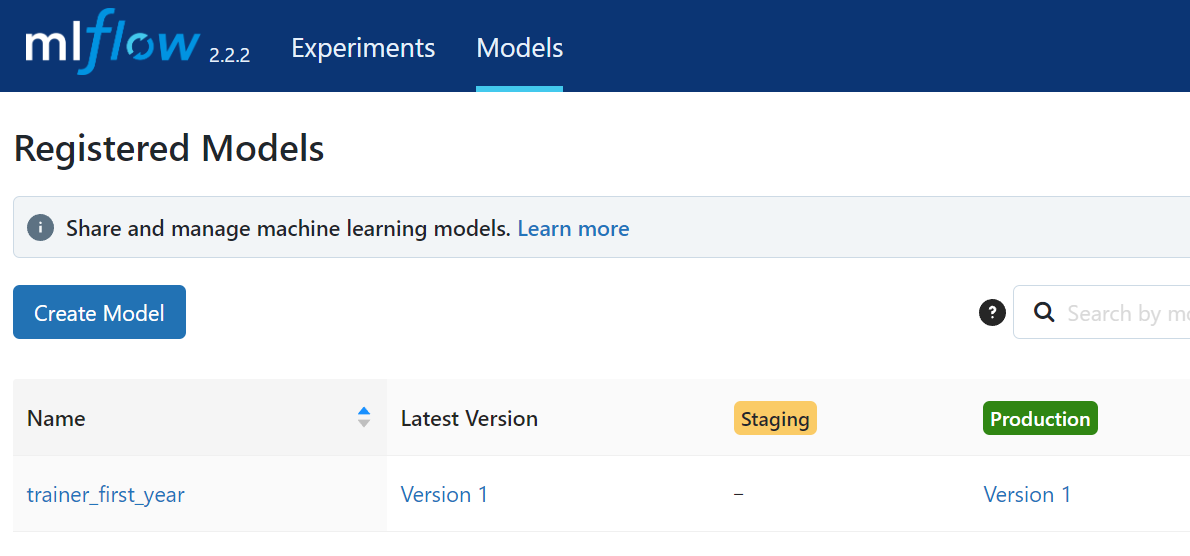

We can also load the model and make predictions

In [7]:
model = MLflowManager.load_model(trainer_first_year.name, '1', 'http://127.0.0.1:5000')
y_preds = model.predict(splitter.X_test)[:5]

Model trainer_first_year loaded from MLflow


So now we have trained a model after 1 year of data, as we mentioned we want to know track if this model is going to perform well on the new incoming data, in a real scenario we could track on daily basis if the input data is drifting and retrain a new model if necessary.

In this case as we already have all the data series, what we are going to do is analyze the drift and after every year rather than on a daily basis.

## 2.3 Second year of data

Imagine that a year has passed and we want to know if the data has changed during this time. Before retrain a new model we could check if the distribution of the input variables has changed

### 2.3.1 Input drift

There are many techniques to check if there is the X variable have drifted, but the idea basically is to check whether the distribution of a period t is equal to the one in period t+1. In this case we are going to use Kolmogorov-Smirnov test for numerical variables and Chi-square test for categorical variables.

There are many other tests and techniques, like train a [domain classifier](https://www.analyticsvidhya.com/blog/2021/10/mlops-and-the-importance-of-data-drift-detection/#:~:text=A%20Machine%20Learning,become%20computationally%20expensive.), to check if there is drift in the input variables, but for the sake of simplicity we are going to use these two. Please check out [this article](https://towardsdatascience.com/mlops-understanding-data-drift-69f9bf8a2e46) to dig deeper into this topic.

In [8]:
first_year_X,  first_year_y= splitter.x_y_filter_by_month(from_month=0, to_month=12)
second_year_X,  second_year_y= splitter.x_y_filter_by_month(from_month=12, to_month=24)


drift_detector = DriftDetector(
    name = 'drift_detector'
    , random_state=SEED
)

drifted_columns = drift_detector.univariate_input_drift(first_year_X, second_year_X)

In [9]:
print(f"Drifted columns: {drifted_columns}")

Drifted columns: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'revol_bal', 'revol_util', 'issue_d_month', 'issue_d_year', 'addr_state_CA', 'purpose_debt_consolidation', 'sub_grade_A5', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified']]


This only means that we need to retrain our model, but let's now check now if the target variable has changed

### 2.3.2 Target drift
As it's a categorical variable we are going to use the Chi-square test to check if the distribution of the target variable has changed.

In [10]:
p_value = DriftDetector.kolmogorow_smirnov_test(first_year_y, second_year_y)

if p_value < 0.05:
    print("Warning: target variable has drifted")

There is also drift in the target variable, so we need to retrain our model. Let's now check if there is concept drift.

### 2.3.3 Concept drift

There also many techniques also available but in this case I chose to just retrain a challenger model and compare it to our model in production. For simplicity and to test both models under the same conditions.



In [11]:
splitter.set_train_test_filtered(number_of_months=24)

trainer_second_year = ClassifierTrainer(
    name = 'trainer_second_year'
    , model_class = DecisionTreeClassifier()
    , random_state=SEED
    , splitter = splitter
    , objective_metric = 'roc_auc'
)

trainer_second_year.set_model_params(
    params = trainer_first_year.params
)

trainer_second_year.train()
trainer_second_year.predict(splitter.X_test)
trainer_second_year.evaluate(splitter.y_test)

mlflow_manager.make_run(run_name='second_year'
                          , experiment_name=experiment_name
                          , trainer=trainer_second_year
                          , log_model=True
                          )

Resampled data. New train size: 2945
Test and train attributes defined 0.3.
        Test size: 1375
        Train size: 2945
X_train shape: (2945, 132)
Model trainer_second_year trained
Model trainer_second_year has made the predictions
Experiment random_forest created in tracking URI http://127.0.0.1:5000


/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Int

Model trainer_second_year logged in MLflow
Run completed


Created version '2' of model 'trainer_second_year'.


If now we start comparing the with the data of the third year both models and the performance is significantly better for the challenger model, it can be an indicative of concept drift.

In [12]:
start_period = 24
end_period = 36
step = 3
model_prod = MLflowManager.load_model(trainer_first_year.name, '1')


metrics = DriftDetector.predict_by_period(start_period = start_period
                  , end_period = end_period
                  , step = 3
                  , model_prod = model_prod
                  , model_challenger = trainer_second_year.model_class
                  , objective_metric = 'roc_auc'
                  , splitter = splitter)

Model trainer_first_year loaded from MLflow
Production model roc_auc: 0.5549829216592898
Challenger model roc_auc: 0.49330045798508526

Production model roc_auc: 0.5413189635635686
Challenger model roc_auc: 0.4972830055649284

Production model roc_auc: 0.5487528344671202
Challenger model roc_auc: 0.4912464985994398

Production model roc_auc: 0.5269743036782797
Challenger model roc_auc: 0.5074560337757799



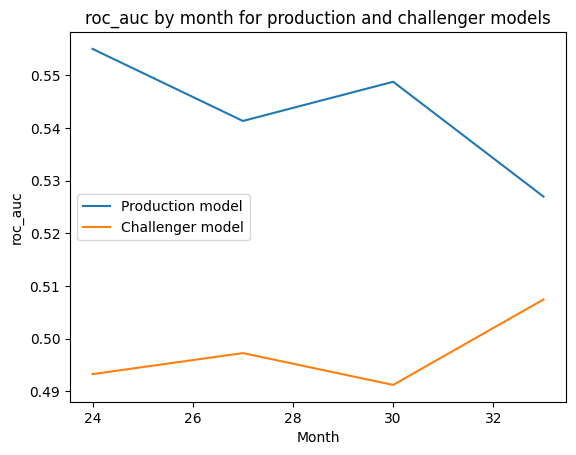

In [13]:
DriftDetector.plot_metric(metrics, 'roc_auc')

Let's now log all the metrics in mlflow for both models, and as the whole year has apssed let's see teh performance of both model with the whole year of data

In [14]:

model_in_production = MLflowManager.load_model(trainer_first_year.name, '1', 'http://127.0.0.1:5000')


third_year_X, third_year_y = splitter.x_y_filter_by_month(from_month=24, to_month=36)

y_preds_production = model_in_production.predict(third_year_X)
metrics_production = ClassifierTrainer.get_metrics(third_year_y, y_preds_production)

mlflow_manager.log_new_metrics(run_name='first_year'
                               , experiment_name=experiment_name
                               , metrics=metrics_production
                               , prefix='Third_year_'
                               )
               

trainer_second_year.predict(third_year_X)
results = trainer_second_year.get_metrics(third_year_y, trainer_second_year.y_pred)
mlflow_manager.log_new_metrics(run_name='second_year'
                               , experiment_name=experiment_name
                               , metrics=trainer_second_year.results
                               , prefix='Third_year_'
                               )
               

print(f"""ROC-AUC for first year model: {trainer_first_year.results['roc_auc']}
ROC-AUC for second year model: {trainer_second_year.results['roc_auc']}""")


Model trainer_first_year loaded from MLflow
Experiment random_forest created in tracking URI http://127.0.0.1:5000
first_year
Model trainer_second_year has made the predictions
Experiment random_forest created in tracking URI http://127.0.0.1:5000
second_year
ROC-AUC for first year model: 0.6240190761771086
ROC-AUC for second year model: 0.5527131584341054


In this case the challenger model doesn't seems to do much better than the production one, so we can assume that there is no concept drift. But ideally we want to automate this, for the whole time series once we have a whole year of new data we are going to decide which model we keep, the challenguer or the production model.

## 2.4 Serving the model as an REST API

In [ ]:
!mlflow models build -m my_model --enable-mlserver -n my-model

## 2.5 Running the whole timeseries


-------------- Executing splitter --------------
Data loaded from ./data/fe_data.csv
Dates data loaded from ./data/dates_data.csv
Test and train attributes defined 0.3.
        Test size: 678201
        Train size: 1582467
--------------- splitter finished ---------------
------------------ Iteration 1 started ------------------
Training model for 2010-06-01 00:00:00 to 2011-06-01 00:00:00
Resampled data. New train size: 1179
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1179
X_train shape: (1179, 132)
Model model_1_year trained
Model model_1_year has made the predictions
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000


/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Int

Model model_1_year logged in MLflow
Run completed
------------------ Iteration 1 finished ------------------

------------------ Iteration 2 started ------------------
Training model for 2011-06-01 00:00:00 to 2012-06-01 00:00:00
Resampled data. New train size: 2945
Test and train attributes defined 0.3.
        Test size: 1375
        Train size: 2945
X_train shape: (2945, 132)
Model model_2_year trained
Model model_2_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'revol_bal', 'revol_util', 'issue_d_month', 'issue_d_year', 'addr_state_CA', 'purpose_debt_consolidation', 'sub_grade_A5', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified']]
Model model_1_year loaded from MLflow
Production model roc_auc: 0.5070894333944713
Challenger model roc_auc: 0.5039812852137813

Production model roc_auc: 0.5417759927479666
Challenger model roc_auc: 0.5091808727620679

Production mode

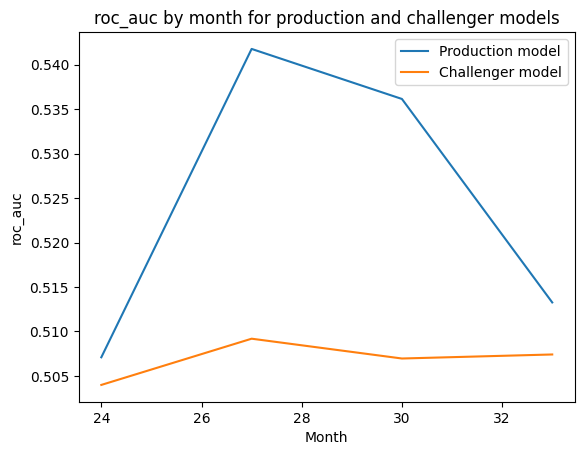

- Challenger roc_auc: 0.50605256192073
- Prod roc_auc: 0.530174838149836
Prod model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_2_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_2_year
------------------ Iteration 2 finished ------------------

------------------ Iteration 3 started ------------------
Training model for 2012-06-01 00:00:00 to 2013-06-01 00:00:00
Resampled data. New train size: 8124
Test and train attributes defined 0.3.
        Test size: 3651
        Train size: 8124
X_train shape: (8124, 132)
Model model_3_year trained
Model model_3_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'revol_util', 'issue_d_month', 'issue_d_year', 'purpose_debt_consolidation', 'purpose_small_business', 've

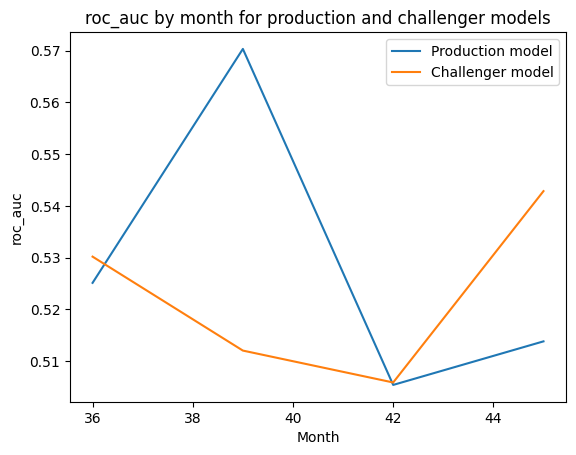

- Challenger roc_auc: 0.5219955334133439
- Prod roc_auc: 0.5292241260452804
Prod model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_3_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_3_year
------------------ Iteration 3 finished ------------------

------------------ Iteration 4 started ------------------
Training model for 2013-06-01 00:00:00 to 2014-06-01 00:00:00
Resampled data. New train size: 15021
Test and train attributes defined 0.3.
        Test size: 6587
        Train size: 15021
X_train shape: (15021, 132)
Model model_4_year trained
Model model_4_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'revol_bal', 'issue_d_month', 'issue_d_year', 'purpose_debt_consolidation', 'purpose_educational', '

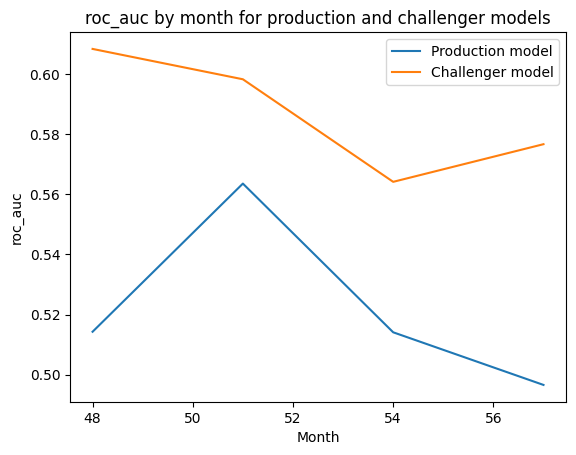

- Challenger roc_auc: 0.5821582550163458
- Prod roc_auc: 0.5137731142457512
Challenger model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000


/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Int

Model model_4_year logged in MLflow
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_4_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_4_year
------------------ Iteration 4 finished ------------------

------------------ Iteration 5 started ------------------
Training model for 2014-06-01 00:00:00 to 2015-06-01 00:00:00
Resampled data. New train size: 30021
Test and train attributes defined 0.3.
        Test size: 13091
        Train size: 30021
X_train shape: (30021, 132)
Model model_5_year trained
Model model_5_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'revol_bal', 'revol_util', 'issue_d_month', 'issue_d_year', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_major_purchase', 'sub_grade_A1', 'sub_grade_A5', 'sub_grade_B3', 'verification_status_Verified']]
Model model_4_year loaded from MLf

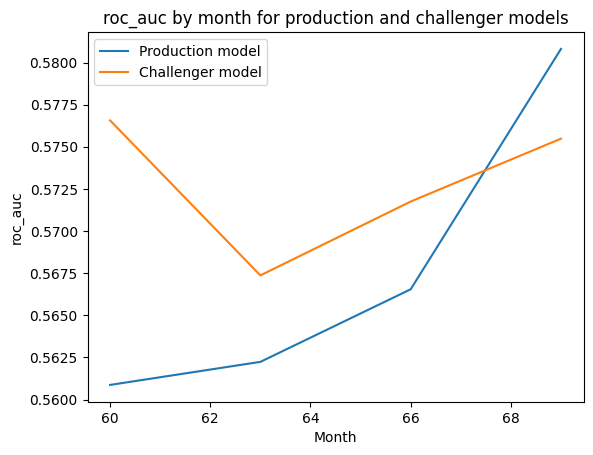

- Challenger roc_auc: 0.5730392241479019
- Prod roc_auc: 0.5684136611218853
Challenger model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000


/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Int

Model model_5_year logged in MLflow
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_5_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_5_year
------------------ Iteration 5 finished ------------------

------------------ Iteration 6 started ------------------
Training model for 2015-06-01 00:00:00 to 2016-06-01 00:00:00
Resampled data. New train size: 77838
Test and train attributes defined 0.3.
        Test size: 34277
        Train size: 77838
X_train shape: (77838, 132)
Model model_6_year trained
Model model_6_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'issue_d_month', 'issue_d_year', 'addr_state_CA', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'initial_list_status

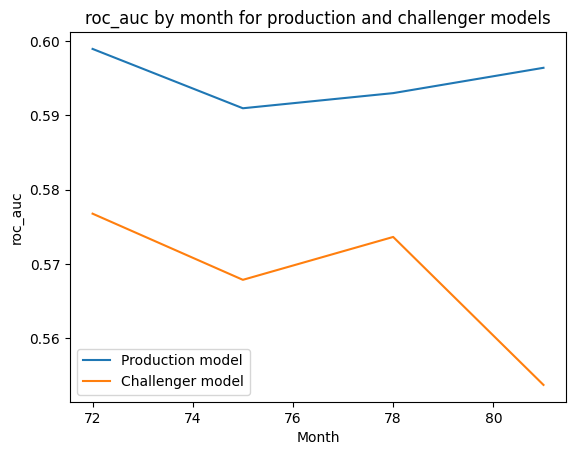

- Challenger roc_auc: 0.5669263234534341
- Prod roc_auc: 0.594834370528968
Prod model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_6_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_6_year
------------------ Iteration 6 finished ------------------

------------------ Iteration 7 started ------------------
Training model for 2016-06-01 00:00:00 to 2017-06-01 00:00:00
Resampled data. New train size: 170248
Test and train attributes defined 0.3.
        Test size: 74899
        Train size: 170248
X_train shape: (170248, 132)
Model model_7_year trained
Model model_7_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_u

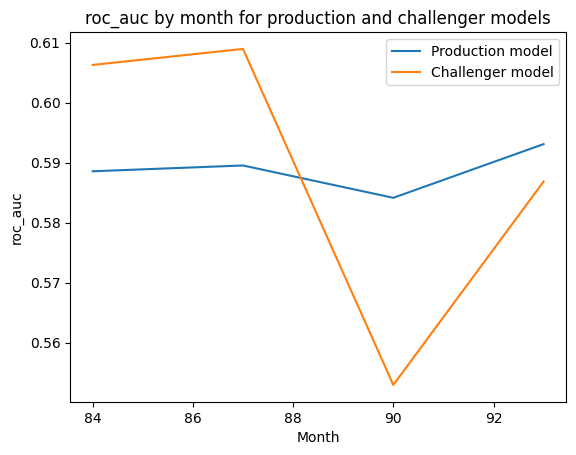

- Challenger roc_auc: 0.5886104429111494
- Prod roc_auc: 0.5888012551084326
Prod model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_7_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_7_year
------------------ Iteration 7 finished ------------------

------------------ Iteration 8 started ------------------
Training model for 2017-06-01 00:00:00 to 2018-06-01 00:00:00
Resampled data. New train size: 316973
Test and train attributes defined 0.3.
        Test size: 141030
        Train size: 316973
X_train shape: (316973, 132)
Model model_8_year trained
Model model_8_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol

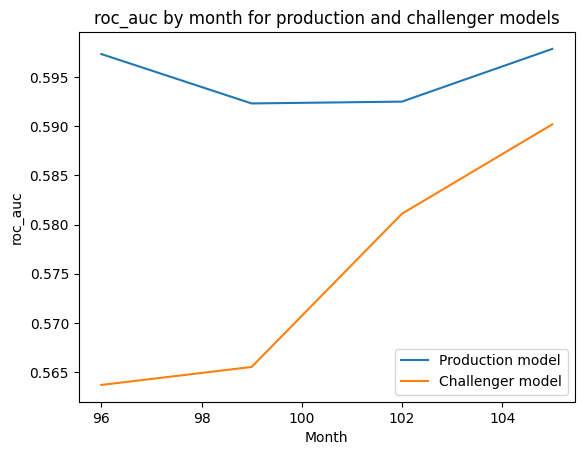

- Challenger roc_auc: 0.5784073374063261
- Prod roc_auc: 0.595425769056496
Prod model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_8_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_8_year
------------------ Iteration 8 finished ------------------

------------------ Iteration 9 started ------------------
Training model for 2018-06-01 00:00:00 to 2019-06-01 00:00:00
Resampled data. New train size: 564547
Test and train attributes defined 0.3.
        Test size: 254295
        Train size: 564547
X_train shape: (564547, 132)
Model model_9_year trained
Model model_9_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'pub_rec', 'revol_bal', 'revol_util', 'tot_coll_amt', '

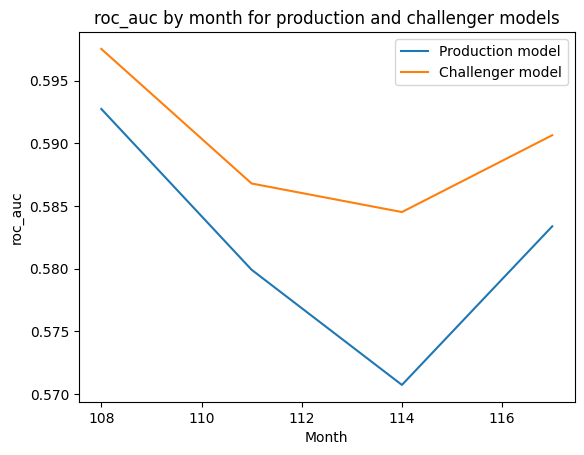

- Challenger roc_auc: 0.5882275111699774
- Prod roc_auc: 0.5813677427525589
Challenger model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000


/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Int

Model model_9_year logged in MLflow
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_9_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_9_year
------------------ Iteration 9 finished ------------------

------------------ Iteration 10 started ------------------
Training model for 2019-06-01 00:00:00 to 2020-06-01 00:00:00
Resampled data. New train size: 825088
Test and train attributes defined 0.3.
        Test size: 373390
        Train size: 825088
X_train shape: (825088, 132)
Model model_10_year trained
Model model_10_year has made the predictions
Drifted variables: [['annual_inc', 'installment', 'int_rate', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'pub_rec', 'pub_rec_bankruptcies', 'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'issue_d_month', 'issue_d_year', 'addr_state_CA', 'application_type_Individual', 'application_type_Joint App', 'home_ownership_MORTGAGE', 'home_o

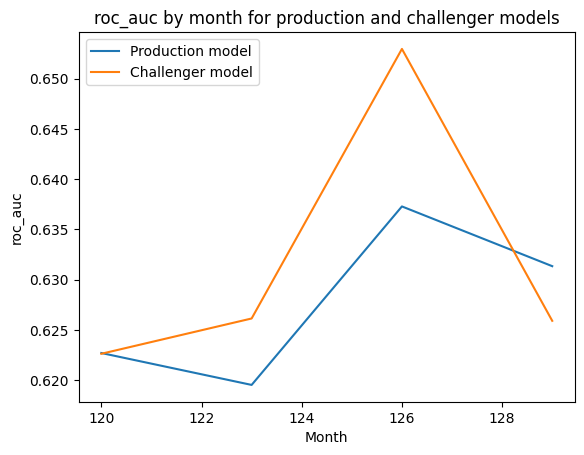

- Challenger roc_auc: 0.6299247851129934
- Prod roc_auc: 0.6276855696057491
Challenger model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000


/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/anaconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Int

Model model_10_year logged in MLflow
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_10_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_10_year
------------------ Iteration 10 finished ------------------

------------------ Iteration 11 started ------------------
Training model for 2020-06-01 00:00:00 to 2021-06-01 00:00:00
Resampled data. New train size: 1154601
Test and train attributes defined 0.3.
        Test size: 516563
        Train size: 1154601
X_train shape: (1154601, 132)
Model model_11_year trained
Model model_11_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'issue_d_month', 'issue_d_year', 'application_type_Individual', 'application_type_Joint App', 'home_owners

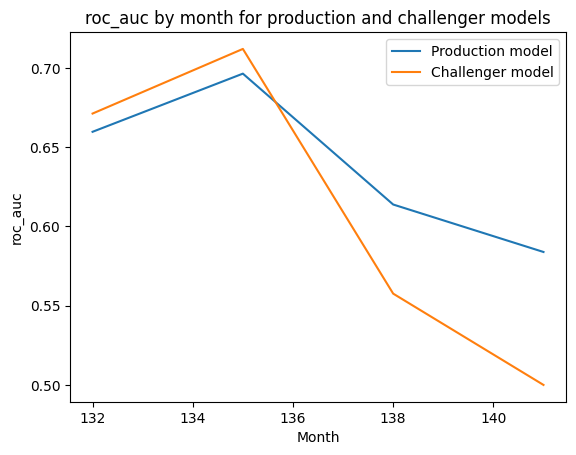

- Challenger roc_auc: 0.6195546224362735
- Prod roc_auc: 0.6425878372282798
Prod model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_11_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_11_year
------------------ Iteration 11 finished ------------------

------------------ Iteration 12 started ------------------
Training model for 2021-06-01 00:00:00 to 2022-06-01 00:00:00
Resampled data. New train size: 1378867
Test and train attributes defined 0.3.
        Test size: 608805
        Train size: 1378867
X_train shape: (1378867, 132)
Model model_12_year trained
Model model_12_year has made the predictions
Drifted variables: [['annual_inc', 'fico_range_high', 'installment', 'int_rate', 'num_bc_sats', 'num_bc_tl', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_uti

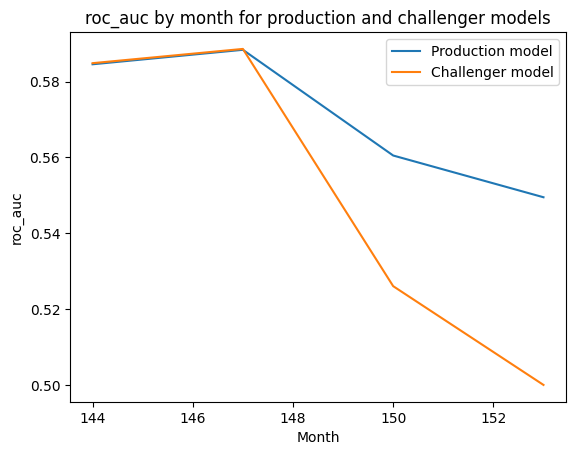

- Challenger roc_auc: 0.5647328552952563
- Prod roc_auc: 0.5726358927123022
Prod model is better!
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
Run completed
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_12_year
Experiment TEST_decision_tree_whole_timeseries created in tracking URI http://127.0.0.1:5000
run_12_year
------------------ Iteration 12 finished ------------------

------------------ Iteration 13 started ------------------
Training model for 2022-06-01 00:00:00 to 2023-06-01 00:00:00


KeyboardInterrupt: 

In [15]:
from modelling import run_whole_timeseries

experiment_name = 'decision_tree_whole_timeseries'

splitter = Splitter(
    name = "splitter"
    , data_path = FE_DATA_PATH
    , date_cols = []
    , target_variable = 'loan_status'
    , destination_directory = DATA_FOLDER
    , dates_data_path = DATES_DATA_PATH
    , column_to_split_by = 'finished_d'
    , test_size = 0.3
    , random_state = SEED
)
splitter.execute()

mlflow_manager =  MLflowManager(
    name = 'mlflow_manager' 
)

prod_model_metrics, prod_model_names = run_whole_timeseries(
                    params={'max_depth': 7}
                    , splitter=splitter
                    , mlflow_manager=mlflow_manager
                    , step=12
                    , random_state=SEED
                    , model_class=DecisionTreeClassifier()
                    , experiment_name = experiment_name
                    , show_plots=True
                    )

